# BrainGAT Evolution: Temporal-Spatial Graph Attention Network

## Overview

This notebook extends the baseline BrainGAT model with novel architectural improvements for ASD classification using **IMAGING-ONLY fMRI data** from the full ABIDE dataset.

---

## Dataset: ABIDE (Autism Brain Imaging Data Exchange)

- **Full Dataset**: ~1,100+ subjects across 20+ sites
- **Data Used**: Complete set with available resting-state fMRI (all successfully downloaded .1D files)
- **Features**: **IMAGING ONLY** - No demographic/phenotypic data used for classification
  - Raw fMRI timeseries: 196 timepoints × 392 ROIs (CC400 atlas)
  - Derived connectivity features: Correlation, Partial Correlation, Mutual Information, Phase Synchrony
- **Labels**: Binary (Control vs ASD) from phenotype file (for ground truth only)

---

## Baseline BrainGAT (What We Started With)

### Architecture:
- **Input**: Correlation matrix (392×392) derived from fMRI timeseries
- **Graph Construction**: k-NN (k=20) based on correlation magnitude
- **Node Features**: Correlation vectors (each ROI's correlations to all other ROIs)
- **Edge Features**: Scalar correlation values
- **Network**: 3-layer GAT with multi-head attention (4 heads)
- **Pooling**: Global mean + max pooling
- **Output**: MLP classifier (2 classes: Control vs ASD)

### Limitations:
1. **Temporal Information Loss**: 196 timepoints collapsed into static correlation matrix
2. **Weak Edge Features**: Only using correlation magnitude (scalar)
3. **Fixed Graph Structure**: k-NN graph doesn't adapt during training
4. **No Multi-Scale Modeling**: Single receptive field for all attention heads
5. **Limited Interpretability**: No mechanism to identify important ROIs or timepoints

### Performance (351 subjects subset):
- Accuracy: ~52% (barely better than random)
- ASD Recall: ~16% (fails to detect ASD)
- **Problem**: Heavy bias toward majority class (Control)

---

## Evolution: What We're Adding

### 1. **Temporal-Spatial Joint Modeling**
**Motivation**: fMRI data has rich temporal dynamics (196 timepoints) that we're currently discarding.

**Implementation**:
- **Temporal Branch**: 1D Conv + Temporal Attention on raw timeseries
  - Learns dynamic patterns (e.g., periodic activations, bursts)
  - Captures temporal dependencies between timepoints
- **Spatial Branch**: GAT on correlation graph (as before)
  - Learns which ROI connections are important
- **Fusion**: Concatenate temporal + spatial features before classification

**Expected Gain**: +5-10% accuracy by exploiting temporal information

### 2. **Rich Edge Features**
**Motivation**: Brain connections have multiple properties beyond correlation.

**Implementation**:
Replace scalar edge weights with 4D edge features:
- **Pearson Correlation**: Linear relationship strength
- **Partial Correlation**: Direct connection (removing confounds)
- **Mutual Information**: Non-linear dependencies
- **Phase Synchrony**: Temporal alignment of signals

**Expected Gain**: +3-5% accuracy by capturing diverse connectivity patterns

### 3. **Multi-Scale Graph Construction**
**Motivation**: Brain operates at multiple spatial scales (local circuits → networks → whole-brain).

**Implementation**:
- Build 3 graphs with different connectivity radii:
  - **Local** (k=10): Short-range connections within regions
  - **Regional** (k=30): Medium-range connections between nearby areas
  - **Global** (k=100): Long-range connections (e.g., DMN)
- Run separate GATs on each scale
- Concatenate multi-scale features

**Expected Gain**: +4-7% accuracy by capturing hierarchical organization

### 4. **Full Dataset Utilization**
- Using **all available subjects** from ABIDE (not just 351)
- Expected ~800-1000 subjects after quality control
- More data = better generalization

---

## Architecture Diagram

```
Input: fMRI Timeseries (N=392 ROIs, T=196 timepoints)
         |
         ├─────────────────┬──────────────────┐
         ↓                 ↓                  ↓
   TEMPORAL BRANCH   SPATIAL BRANCH   EDGE FEATURES
         |                 |                  |
   1D Conv (T→64)    Correlation Matrix   Pearson Corr
         |                 |              Partial Corr
   Temporal Attn     k-NN Graph (3 scales)  Mutual Info
         |                 |              Phase Sync
   Pool (64→32)      Multi-Scale GAT        |
         |                 |                  |
         └─────────────────┴──────────────────┘
                           ↓
                   Concatenate Features
                           ↓
                      MLP Classifier
                           ↓
                  [Control / ASD]
```

---

## Expected Performance

- **Baseline BrainGAT** (351 subjects): 52% accuracy, 16% ASD recall
- **Target (Evolution)**: 68-72% accuracy, 55-65% ASD recall
- This would be competitive with state-of-the-art on ABIDE (BrainGNN: 71-74%)

---

## Novelty Contributions

1. **Joint Temporal-Spatial Modeling**: First to combine 1D temporal convolutions with graph attention for fMRI
2. **Multi-Modal Edge Features**: Using 4 complementary connectivity measures simultaneously
3. **Multi-Scale Hierarchical GAT**: Explicitly modeling brain's hierarchical organization
4. **Imaging-Only**: Pure neuroimaging approach (no demographic confounds)

---

Let's implement it!

In [3]:
!nvidia-smi
import torch
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")

Tue Dec  9 13:20:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             26W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
# Enhanced Data Loading with Temporal Features & Rich Edge Features
import numpy as np
import pandas as pd
from glob import glob
import torch
from torch_geometric.data import Data
from pathlib import Path

def load_timeseries_1d(path: str) -> np.ndarray:
    """Load .1D file as T×N array (196 timepoints × 392 ROIs)"""
    arr = np.loadtxt(path)
    
    # Ensure correct orientation: T×N (196×392)
    # Some files may be stored as N×T, so transpose if needed
    if arr.shape[0] == 392 and arr.shape[1] == 196:
        arr = arr.T
    elif arr.shape[0] != 196 or arr.shape[1] != 392:
        # Skip files with unexpected dimensions
        raise ValueError(f"Unexpected dimensions: {arr.shape}. Expected (196, 392) or (392, 196)")
    
    return arr

def compute_partial_correlation(ts: np.ndarray) -> np.ndarray:
    """Compute partial correlation matrix (removes indirect effects)"""
    corr = np.corrcoef(ts, rowvar=False)
    try:
        # Add small regularization to ensure positive definiteness
        corr_reg = corr + np.eye(corr.shape[0]) * 1e-6
        
        # Partial correlation = negative normalized inverse covariance
        precision = np.linalg.inv(corr_reg)
        
        # Take absolute value of diagonal before sqrt to avoid negatives
        diag_vals = np.diag(precision)
        diag = np.sqrt(np.abs(diag_vals))
        
        # Avoid division by zero
        diag = np.where(diag < 1e-10, 1e-10, diag)
        
        partial = -precision / np.outer(diag, diag)
        np.fill_diagonal(partial, 1.0)
        
        # Clip to valid correlation range and handle NaNs
        partial = np.clip(partial, -1.0, 1.0)
        partial = np.nan_to_num(partial, nan=0.0, posinf=0.0, neginf=0.0)
        
        return partial
    except np.linalg.LinAlgError:
        return np.zeros_like(corr)

def compute_mutual_information(ts: np.ndarray) -> np.ndarray:
    """Compute mutual information matrix (captures non-linear dependencies)"""
    from scipy.stats import spearmanr
    import warnings
    
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        mi_matrix, _ = spearmanr(ts, axis=0)
    
    mi_matrix = np.abs(mi_matrix)
    mi_matrix = np.nan_to_num(mi_matrix, nan=0.0, posinf=0.0, neginf=0.0)
    
    max_val = np.max(mi_matrix)
    if max_val > 1e-8:
        mi_matrix = mi_matrix / max_val
    
    return mi_matrix

def compute_phase_synchrony(ts: np.ndarray) -> np.ndarray:
    """Compute phase synchronization via Hilbert transform (vectorized)"""
    from scipy.signal import hilbert
    
    N = ts.shape[1]
    analytic = hilbert(ts, axis=0)
    phases = np.angle(analytic)
    
    phase_diff = phases[:, :, np.newaxis] - phases[:, np.newaxis, :]
    plv = np.abs(np.mean(np.exp(1j * phase_diff), axis=0))
    
    return plv

def build_multiscale_graphs(ts: np.ndarray, k_values=[10, 30, 100]):
    """Build multiple graphs at different connectivity scales"""
    import warnings
    
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        
        corr = np.corrcoef(ts, rowvar=False)
        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        corr = np.clip(corr, -1.0, 1.0)
        
        partial = compute_partial_correlation(ts)
        
        ts_downsampled = ts[::4, :]
        mi = compute_mutual_information(ts_downsampled)
        plv = compute_phase_synchrony(ts_downsampled)
    
    N = corr.shape[0]
    graphs = []
    
    for k in k_values:
        np.fill_diagonal(corr, 0.0)
        absC = np.abs(corr)
        k_eff = min(k, max(1, N - 1))
        
        edge_src, edge_dst, edge_feats = [], [], []
        
        for i in range(N):
            nbrs = np.argpartition(absC[i], -k_eff)[-k_eff:]
            for j in nbrs:
                if i != j:
                    edge_src.append(i)
                    edge_dst.append(j)
                    edge_feats.append([corr[i, j], partial[i, j], mi[i, j], plv[i, j]])
        
        edge_index = np.vstack([edge_src + edge_dst, edge_dst + edge_src])
        edge_attr = np.vstack([edge_feats, edge_feats])
        
        pairs = {}
        for idx, (s, d) in enumerate(edge_index.T):
            key = (min(s, d), max(s, d))
            if key not in pairs:
                pairs[key] = edge_attr[idx]
        
        final_edges = list(pairs.keys())
        final_src = [e[0] for e in final_edges]
        final_dst = [e[1] for e in final_edges]
        final_attr = np.array([pairs[e] for e in final_edges])
        
        final_src_bi = final_src + final_dst
        final_dst_bi = final_dst + final_src
        final_attr_bi = np.vstack([final_attr, final_attr])
        
        edge_index_tensor = torch.tensor([final_src_bi, final_dst_bi], dtype=torch.long)
        edge_attr_tensor = torch.tensor(final_attr_bi, dtype=torch.float)
        
        graphs.append((edge_index_tensor, edge_attr_tensor))
    
    return graphs, corr

def graph_from_timeseries_enhanced(timeseries: np.ndarray, k_values=[10, 30, 100]):
    """Build enhanced graph with temporal features + multi-scale spatial graphs"""
    ts_tensor = torch.tensor(timeseries.T, dtype=torch.float)
    graphs, corr = build_multiscale_graphs(timeseries, k_values)
    x = torch.tensor(corr, dtype=torch.float)
    
    data = Data(
        x=x,
        timeseries=ts_tensor,
    )
    
    for i, (edge_idx, edge_attr) in enumerate(graphs):
        setattr(data, f'edge_index_{i}', edge_idx)
        setattr(data, f'edge_attr_{i}', edge_attr)
    
    return data

def load_abide_graphs_enhanced(data_dir, phenotype_file, k_values=[10, 30, 100]):
    """Load ABIDE with enhanced features"""
    pheno_df = pd.read_csv(phenotype_file)
    roi_files = sorted(glob(f'{data_dir}/*.1D'))
    
    print(f"Loading ABIDE data (Enhanced Mode)...")
    print(f"   Multi-scale k values: {k_values}")
    print(f"   Edge features: [Correlation, Partial Corr, MI, Phase Sync]")
    
    graphs, labels, subjects = [], [], []
    
    site_map = {
        'MaxMun': 'MAX_MUN', 'Leuven_1': 'LEUVEN_1', 'Leuven_2': 'LEUVEN_2',
        'UCLA_1': 'UCLA_1', 'UCLA_2': 'UCLA_2', 'UM_1': 'UM_1', 'UM_2': 'UM_2',
        'Trinity': 'TRINITY', 'Yale': 'YALE', 'Olin': 'OLIN', 'OHSU': 'OHSU',
        'SBL': 'SBL', 'SDSU': 'SDSU', 'Stanford': 'STANFORD', 'Caltech': 'CALTECH',
        'CMU': 'CMU', 'KKI': 'KKI', 'NYU': 'NYU', 'Pitt': 'PITT', 'USM': 'USM'
    }
    
    for idx, file_path in enumerate(roi_files):
        if idx % 50 == 0:
            print(f"   Processing subject {idx+1}/{len(roi_files)}...")
        
        try:
            filename = Path(file_path).stem
            parts = filename.replace('_rois_cc400', '').split('_')
            
            if len(parts) < 2:
                continue
            
            site = parts[0]
            subject_id_idx = 1
            
            if len(parts) > 2 and parts[1].isdigit() and len(parts[1]) == 1:
                site = f"{parts[0]}_{parts[1]}"
                subject_id_idx = 2
            
            if site in site_map:
                site = site_map[site]
            elif site.upper() in site_map.values():
                site = site.upper()
            
            subject_id = None
            for part in parts[subject_id_idx:]:
                try:
                    subject_id = int(part)
                    break
                except ValueError:
                    continue
            
            if subject_id is None:
                continue
            
            subject_row = pheno_df[
                (pheno_df['SITE_ID'] == site) & 
                (pheno_df['SUB_ID'] == subject_id)
            ]
            
            if not subject_row.empty:
                dx_group = subject_row['DX_GROUP'].values[0]
                
                if dx_group in [1, 2]:
                    try:
                        ts = load_timeseries_1d(file_path)
                    except (ValueError, Exception) as e:
                        # Skip files with wrong dimensions or loading errors
                        continue
                    
                    # Quality check: verify final shape is (196, 392)
                    if ts.shape != (196, 392):
                        continue
                    
                    # Quality check: no NaN/Inf values
                    if np.any(np.isnan(ts)) or np.any(np.isinf(ts)):
                        continue
                    
                    # Quality check: no constant columns (zero variance)
                    col_std = np.std(ts, axis=0)
                    if np.any(col_std < 1e-10):
                        continue
                    
                    graph = graph_from_timeseries_enhanced(ts, k_values=k_values)
                    graph.y = torch.tensor([dx_group - 1], dtype=torch.long)
                    
                    graphs.append(graph)
                    labels.append(dx_group - 1)
                    subjects.append(f"{site}_{subject_id}")
        except Exception as e:
            print(f"   Error processing {file_path}: {e}")
            continue
    
    print(f"\nLoaded {len(graphs)} subjects")
    print(f"   ASD: {labels.count(1)} | Control: {labels.count(0)}")
    
    return graphs, labels, subjects

print("Enhanced data loading functions defined")

Enhanced data loading functions defined


In [8]:
# Install Dependencies (Optimized for Pre-built Wheels)
import torch
import sys

# Get PyTorch and CUDA versions
torch_ver = torch.__version__.split('+')[0]
cuda_ver = torch.version.cuda.replace('.', '') if torch.cuda.is_available() else 'cpu'

print(f"🔧 Installing PyG for PyTorch {torch_ver} + CUDA {cuda_ver}")
print(f"   Using pre-built wheels to avoid slow compilation...")

# Install with correct wheel index
wheel_url = f"https://data.pyg.org/whl/torch-{torch_ver}+cu{cuda_ver}.html"
!pip install -q torch-geometric torch-scatter torch-sparse -f {wheel_url}

print("✅ Dependencies installed.")

🔧 Installing PyG for PyTorch 2.6.0 + CUDA 124
   Using pre-built wheels to avoid slow compilation...
✅ Dependencies installed.
✅ Dependencies installed.


In [9]:
# Download ABIDE Data (Reuse from BrainGAT)
import os
import urllib.request as request
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Config
OUT_DIR = 'abide_data/Outputs/cpac/nofilt_noglobal/rois_cc400'
PIPELINE = 'cpac'
STRATEGY = 'nofilt_noglobal'
DERIVATIVE = 'rois_cc400'
EXTENSION = '.1D'

os.makedirs(OUT_DIR, exist_ok=True)

# 1. Download Phenotype File
print("🚀 Downloading Phenotype Data...")
pheno_url = 'https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv'
pheno_file = 'Phenotypic_V1_0b_preprocessed1.csv'
if not os.path.exists(pheno_file):
    request.urlretrieve(pheno_url, pheno_file)
print("✅ Phenotype data ready.")

# 2. Download .1D Files in Parallel
print(f"\n🚀 Downloading {DERIVATIVE} files from S3 (Parallel)...")

df = pd.read_csv(pheno_file)
file_ids = df['FILE_ID'].tolist()
file_ids = [f for f in file_ids if f != 'no_filename']

base_url = f'https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/{PIPELINE}/{STRATEGY}/{DERIVATIVE}'

def download_file(file_id):
    filename = f"{file_id}_{DERIVATIVE}{EXTENSION}"
    url = f"{base_url}/{filename}"
    out_path = os.path.join(OUT_DIR, filename)
    
    if os.path.exists(out_path):
        return "Exists"
        
    try:
        request.urlretrieve(url, out_path)
        return "Downloaded"
    except Exception as e:
        return f"Error: {e}"

print(f"   Target: {len(file_ids)} files")
print("   Starting download pool (max_workers=8)...")

with ThreadPoolExecutor(max_workers=8) as executor:
    results = list(tqdm(executor.map(download_file, file_ids), total=len(file_ids)))

success = results.count("Downloaded") + results.count("Exists")
errors = len(results) - success

print(f"\n✅ Download Complete!")
print(f"   Success: {success}")
print(f"   Errors:  {errors}")
print(f"   Data directory: {OUT_DIR}")

🚀 Downloading Phenotype Data...
✅ Phenotype data ready.

🚀 Downloading rois_cc400 files from S3 (Parallel)...
   Target: 1035 files
   Starting download pool (max_workers=8)...
✅ Phenotype data ready.

🚀 Downloading rois_cc400 files from S3 (Parallel)...
   Target: 1035 files
   Starting download pool (max_workers=8)...


100%|██████████| 1035/1035 [03:17<00:00,  5.25it/s]


✅ Download Complete!
   Success: 1035
   Errors:  0
   Data directory: abide_data/Outputs/cpac/nofilt_noglobal/rois_cc400


In [10]:
# Imports & Setup
import os
import sys
import subprocess
import importlib
import torch

def install_dependencies():
    print("Installing torch-geometric and dependencies...")
    torch_ver = torch.__version__.split('+')[0]
    cuda_ver = "cpu"
    
    if torch.cuda.is_available():
        cuda_ver = "cu" + torch.version.cuda.replace('.', '')
    
    wheel_url = f"https://data.pyg.org/whl/torch-{torch_ver}+{cuda_ver}.html"
    print(f"   Targeting wheels from: {wheel_url}")

    pkgs = ["torch-scatter", "torch-sparse", "torch-geometric"]
    cmd = [sys.executable, "-m", "pip", "install", "-q"] + pkgs + ["-f", wheel_url]
    
    try:
        subprocess.check_call(cmd)
        print("Dependencies installed.")
    except subprocess.CalledProcessError:
        print("Warning: Wheel installation failed, falling back to default pip install...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

    importlib.invalidate_caches()

try:
    import torch_geometric
except ImportError:
    install_dependencies()

import torch_geometric
import glob
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool, global_max_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as PyGDataLoader
from sklearn.model_selection import train_test_split
from pathlib import Path
from scipy import stats
from sklearn.feature_selection import mutual_info_regression

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"   GPU: {gpu_name}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
   GPU: Tesla P100-PCIE-16GB
   Memory: 17.06 GB


In [11]:
# Enhanced Data Loading with Sliding Temporal Windows

def load_timeseries_1d(path: str) -> np.ndarray:
    """Load .1D file as T×N array
    
    Returns:
        Array of shape (T, 392) where T varies by subject
    """
    arr = np.loadtxt(path)
    
    # Ensure correct orientation: T×N (time × ROIs)
    # Check if we need to transpose (ROIs should be 392 for CC400 atlas)
    if arr.shape[1] == 392:
        # Already T×N format
        pass
    elif arr.shape[0] == 392:
        # N×T format, transpose to T×N
        arr = arr.T
    else:
        # Neither dimension is 392 - invalid file
        raise ValueError(f"Expected 392 ROIs, got shape {arr.shape}")
    
    T, N = arr.shape
    
    # Validate ROI count
    if N != 392:
        raise ValueError(f"Expected 392 ROIs, got {N}")
    
    return arr

def extract_temporal_windows(timeseries: np.ndarray, window_length: int = 80, stride: int = 20):
    """Extract sliding windows from timeseries
    
    Args:
        timeseries: Array of shape (T, N) where T=timepoints, N=ROIs
        window_length: Length of each window in TRs (default: 80 TRs ≈ 160s @ TR=2s)
        stride: Step size between windows (default: 20 TRs ≈ 40s overlap)
    
    Returns:
        List of arrays, each of shape (window_length, N)
    """
    T, N = timeseries.shape
    
    # Skip if timeseries too short
    if T < window_length:
        return []
    
    windows = []
    for start in range(0, T - window_length + 1, stride):
        end = start + window_length
        window = timeseries[start:end, :]
        windows.append(window)
    
    return windows

def compute_partial_correlation(ts: np.ndarray) -> np.ndarray:
    """Compute partial correlation matrix (removes indirect effects)"""
    corr = np.corrcoef(ts, rowvar=False)
    try:
        # Add small regularization to ensure positive definiteness
        corr_reg = corr + np.eye(corr.shape[0]) * 1e-6
        
        # Partial correlation = negative normalized inverse covariance
        precision = np.linalg.inv(corr_reg)
        
        # Take absolute value of diagonal before sqrt to avoid negatives
        diag_vals = np.diag(precision)
        diag = np.sqrt(np.abs(diag_vals))
        
        # Avoid division by zero
        diag = np.where(diag < 1e-10, 1e-10, diag)
        
        partial = -precision / np.outer(diag, diag)
        np.fill_diagonal(partial, 1.0)
        
        # Clip to valid correlation range and handle NaNs
        partial = np.clip(partial, -1.0, 1.0)
        partial = np.nan_to_num(partial, nan=0.0, posinf=0.0, neginf=0.0)
        
        return partial
    except np.linalg.LinAlgError:
        return np.zeros_like(corr)

def compute_mutual_information(ts: np.ndarray) -> np.ndarray:
    """Compute mutual information matrix (captures non-linear dependencies)"""
    from scipy.stats import spearmanr
    import warnings
    
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        mi_matrix, _ = spearmanr(ts, axis=0)
    
    mi_matrix = np.abs(mi_matrix)
    mi_matrix = np.nan_to_num(mi_matrix, nan=0.0, posinf=0.0, neginf=0.0)
    
    max_val = np.max(mi_matrix)
    if max_val > 1e-8:
        mi_matrix = mi_matrix / max_val
    
    return mi_matrix

def compute_phase_synchrony(ts: np.ndarray) -> np.ndarray:
    """Compute phase synchronization via Hilbert transform (vectorized)"""
    from scipy.signal import hilbert
    
    N = ts.shape[1]
    analytic = hilbert(ts, axis=0)
    phases = np.angle(analytic)
    
    phase_diff = phases[:, :, np.newaxis] - phases[:, np.newaxis, :]
    plv = np.abs(np.mean(np.exp(1j * phase_diff), axis=0))
    
    return plv

def build_multiscale_graphs(ts: np.ndarray, k_values=[10, 30, 100]):
    """Build multiple graphs at different connectivity scales"""
    import warnings
    
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        
        corr = np.corrcoef(ts, rowvar=False)
        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        corr = np.clip(corr, -1.0, 1.0)
        
        partial = compute_partial_correlation(ts)
        
        ts_downsampled = ts[::4, :]
        mi = compute_mutual_information(ts_downsampled)
        plv = compute_phase_synchrony(ts_downsampled)
    
    N = corr.shape[0]
    graphs = []
    
    for k in k_values:
        np.fill_diagonal(corr, 0.0)
        absC = np.abs(corr)
        k_eff = min(k, max(1, N - 1))
        
        edge_src, edge_dst, edge_feats = [], [], []
        
        for i in range(N):
            nbrs = np.argpartition(absC[i], -k_eff)[-k_eff:]
            for j in nbrs:
                if i != j:
                    edge_src.append(i)
                    edge_dst.append(j)
                    edge_feats.append([corr[i, j], partial[i, j], mi[i, j], plv[i, j]])
        
        edge_index = np.vstack([edge_src + edge_dst, edge_dst + edge_src])
        edge_attr = np.vstack([edge_feats, edge_feats])
        
        pairs = {}
        for idx, (s, d) in enumerate(edge_index.T):
            key = (min(s, d), max(s, d))
            if key not in pairs:
                pairs[key] = edge_attr[idx]
        
        final_edges = list(pairs.keys())
        final_src = [e[0] for e in final_edges]
        final_dst = [e[1] for e in final_edges]
        final_attr = np.array([pairs[e] for e in final_edges])
        
        final_src_bi = final_src + final_dst
        final_dst_bi = final_dst + final_src
        final_attr_bi = np.vstack([final_attr, final_attr])
        
        edge_index_tensor = torch.tensor([final_src_bi, final_dst_bi], dtype=torch.long)
        edge_attr_tensor = torch.tensor(final_attr_bi, dtype=torch.float)
        
        graphs.append((edge_index_tensor, edge_attr_tensor))
    
    return graphs, corr

def graph_from_timeseries_enhanced(timeseries: np.ndarray, k_values=[10, 30, 100]):
    """Build enhanced graph with temporal features + multi-scale spatial graphs"""
    ts_tensor = torch.tensor(timeseries.T, dtype=torch.float)
    graphs, corr = build_multiscale_graphs(timeseries, k_values)
    x = torch.tensor(corr, dtype=torch.float)
    
    data = Data(
        x=x,
        timeseries=ts_tensor,
    )
    
    for i, (edge_idx, edge_attr) in enumerate(graphs):
        setattr(data, f'edge_index_{i}', edge_idx)
        setattr(data, f'edge_attr_{i}', edge_attr)
    
    return data

def load_abide_graphs_enhanced(data_dir, phenotype_file, k_values=[10, 30, 100], 
                                window_length=80, stride=20):
    """Load ABIDE with sliding temporal windows for data augmentation
    
    Args:
        data_dir: Directory containing .1D files
        phenotype_file: Path to phenotype CSV
        k_values: Multi-scale k values for graph construction
        window_length: Window size in TRs (default: 80 TRs ≈ 160s @ TR=2s)
        stride: Stride between windows in TRs (default: 20 TRs ≈ 40s)
    
    Returns:
        graphs, labels, subjects (each window is a separate sample)
    """
    pheno_df = pd.read_csv(phenotype_file)
    roi_files = sorted(glob.glob(f'{data_dir}/*.1D'))
    
    print(f"Loading ABIDE data with Sliding Temporal Windows...")
    print(f"   Window length: {window_length} TRs (~{window_length*2}s @ TR=2s)")
    print(f"   Stride: {stride} TRs (~{stride*2}s)")
    print(f"   Multi-scale k values: {k_values}")
    print(f"   Edge features: [Correlation, Partial Corr, MI, Phase Sync]")
    
    graphs, labels, subjects = [], [], []
    window_counts = []
    
    site_map = {
        'MaxMun': 'MAX_MUN', 'Leuven_1': 'LEUVEN_1', 'Leuven_2': 'LEUVEN_2',
        'UCLA_1': 'UCLA_1', 'UCLA_2': 'UCLA_2', 'UM_1': 'UM_1', 'UM_2': 'UM_2',
        'Trinity': 'TRINITY', 'Yale': 'YALE', 'Olin': 'OLIN', 'OHSU': 'OHSU',
        'SBL': 'SBL', 'SDSU': 'SDSU', 'Stanford': 'STANFORD', 'Caltech': 'CALTECH',
        'CMU': 'CMU', 'KKI': 'KKI', 'NYU': 'NYU', 'Pitt': 'PITT', 'USM': 'USM'
    }
    
    for idx, file_path in enumerate(roi_files):
        if idx % 50 == 0:
            print(f"   Processing subject {idx+1}/{len(roi_files)}...")
        
        try:
            filename = Path(file_path).stem
            parts = filename.replace('_rois_cc400', '').split('_')
            
            if len(parts) < 2:
                continue
            
            site = parts[0]
            subject_id_idx = 1
            
            if len(parts) > 2 and parts[1].isdigit() and len(parts[1]) == 1:
                site = f"{parts[0]}_{parts[1]}"
                subject_id_idx = 2
            
            if site in site_map:
                site = site_map[site]
            elif site.upper() in site_map.values():
                site = site.upper()
            
            subject_id = None
            for part in parts[subject_id_idx:]:
                try:
                    subject_id = int(part)
                    break
                except ValueError:
                    continue
            
            if subject_id is None:
                continue
            
            subject_row = pheno_df[
                (pheno_df['SITE_ID'] == site) & 
                (pheno_df['SUB_ID'] == subject_id)
            ]
            
            if not subject_row.empty:
                dx_group = subject_row['DX_GROUP'].values[0]
                
                if dx_group in [1, 2]:
                    try:
                        ts = load_timeseries_1d(file_path)
                    except (ValueError, Exception) as e:
                        # Skip files with wrong ROI count or loading errors
                        continue
                    
                    # Quality check: no NaN/Inf values
                    if np.any(np.isnan(ts)) or np.any(np.isinf(ts)):
                        continue
                    
                    # Quality check: no constant columns (zero variance)
                    col_std = np.std(ts, axis=0)
                    if np.any(col_std < 1e-10):
                        continue
                    
                    # Extract sliding windows
                    windows = extract_temporal_windows(ts, window_length, stride)
                    
                    if len(windows) == 0:
                        continue
                    
                    window_counts.append(len(windows))
                    
                    # Create a graph for each window
                    for window in windows:
                        graph = graph_from_timeseries_enhanced(window, k_values=k_values)
                        graph.y = torch.tensor([dx_group - 1], dtype=torch.long)
                        
                        graphs.append(graph)
                        labels.append(dx_group - 1)
                        subjects.append(f"{site}_{subject_id}")
                        
        except Exception as e:
            print(f"   Error processing {file_path}: {e}")
            continue
    
    print(f"\n✅ Loaded {len(graphs)} windows from {len(window_counts)} subjects")
    print(f"   ASD: {labels.count(1)} | Control: {labels.count(0)}")
    print(f"   Avg windows per subject: {np.mean(window_counts):.1f}")
    print(f"   Min/Max windows: {np.min(window_counts)}/{np.max(window_counts)}")
    
    return graphs, labels, subjects

print("Enhanced data loading functions defined (Sliding Windows)")

Enhanced data loading functions defined (Sliding Windows)


In [12]:
# DIAGNOSTIC: Check actual file dimensions
import glob
import numpy as np
from collections import Counter

roi_files = sorted(glob.glob('abide_data/Outputs/cpac/nofilt_noglobal/rois_cc400/*.1D'))
print(f"Analyzing {len(roi_files)} .1D files...\n")

shapes = []
for f in roi_files:
    try:
        arr = np.loadtxt(f)
        shapes.append(arr.shape)
    except:
        shapes.append(None)

print("Sample file dimensions (first 10):")
for f, s in zip(roi_files[:10], shapes[:10]):
    print(f"  {f.split('/')[-1]}: {s}")

print(f"\nShape Distribution (all {len(roi_files)} files):")
shape_counts = Counter(shapes)
for shape, count in sorted(shape_counts.items(), key=lambda x: -x[1])[:10]:
    if shape:
        pct = 100 * count / len(roi_files)
        print(f"  {shape[0]:3d} × {shape[1]:3d}: {count:4d} files ({pct:5.1f}%)")

# Find most common shape
most_common_shape = shape_counts.most_common(1)[0][0]
print(f"\nMost common shape: {most_common_shape}")
print(f"   This will be our target dimension.")

Analyzing 1035 .1D files...

Sample file dimensions (first 10):
  CMU_a_0050642_rois_cc400.1D: (236, 392)
  CMU_a_0050646_rois_cc400.1D: (236, 392)
  CMU_a_0050647_rois_cc400.1D: (202, 392)
  CMU_a_0050649_rois_cc400.1D: (236, 392)
  CMU_a_0050653_rois_cc400.1D: (236, 392)
  CMU_a_0050654_rois_cc400.1D: (236, 392)
  CMU_a_0050656_rois_cc400.1D: (236, 392)
  CMU_a_0050659_rois_cc400.1D: (236, 392)
  CMU_a_0050660_rois_cc400.1D: (236, 392)
  CMU_a_0050663_rois_cc400.1D: (236, 392)

Shape Distribution (all 1035 files):
  176 × 392:  227 files ( 21.9%)
  196 × 392:  158 files ( 15.3%)
  296 × 392:  140 files ( 13.5%)
  116 × 392:  134 files ( 12.9%)
  236 × 392:  103 files ( 10.0%)
  146 × 392:   84 files (  8.1%)
  246 × 392:   63 files (  6.1%)
  152 × 392:   42 files (  4.1%)
  206 × 392:   34 files (  3.3%)
   78 × 392:   26 files (  2.5%)

Most common shape: (176, 392)
   This will be our target dimension.
Sample file dimensions (first 10):
  CMU_a_0050642_rois_cc400.1D: (236, 392)
  

## Model Architecture: Temporal-Spatial BrainGAT

This model has three main components:

1. **Temporal Branch**: Processes raw timeseries with 1D convolutions + temporal attention
2. **Spatial Branch**: Multi-scale GAT on correlation graphs (3 scales: local, regional, global)
3. **ROI Attention Pooling**: Learns which brain regions are important for classification

In [13]:
# Temporal Branch: 1D CNN + Temporal Attention

class TemporalAttention(nn.Module):
    """Attention over time dimension"""
    def __init__(self, hidden_dim):
        super().__init__()
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        
    def forward(self, x):
        # x: (batch*N, T, hidden)
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        
        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(Q.size(-1))
        attn_weights = F.softmax(scores, dim=-1)
        out = torch.matmul(attn_weights, V)
        
        return out

class TemporalBranch(nn.Module):
    """Extract temporal features from fMRI timeseries"""
    def __init__(self, input_time_len=80, hidden_dim=64):
        super().__init__()
        # 1D Convolutions over time: (batch*N, 1, T) -> (batch*N, hidden, T)
        self.conv1 = nn.Conv1d(1, hidden_dim, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        
        # Temporal Attention
        self.temporal_attn = TemporalAttention(hidden_dim)
        
        # Pooling
        self.pool = nn.AdaptiveAvgPool1d(1)
        
    def forward(self, timeseries, batch):
        # timeseries: (batch*N, T)
        x = timeseries.unsqueeze(1)  # (batch*N, 1, T)
        
        # Conv layers
        x = F.relu(self.bn1(self.conv1(x)))  # (batch*N, hidden, T)
        x = F.relu(self.bn2(self.conv2(x)))  # (batch*N, hidden, T)
        
        # Transpose for attention (batch*N, T, hidden)
        x = x.transpose(1, 2)
        
        # Temporal attention
        x = self.temporal_attn(x)  # (batch*N, T, hidden)
        
        # Pool over time
        x = x.transpose(1, 2)  # (batch*N, hidden, T)
        x = self.pool(x).squeeze(-1)  # (batch*N, hidden)
        
        # Pool over nodes to get graph-level features
        x_graph = global_mean_pool(x, batch)  # (batch, hidden)
        
        return x_graph

print("Temporal branch defined")

Temporal branch defined


In [14]:
# Spatial Branch: Multi-Scale GAT with Rich Edge Features

class MultiHeadGATLayerWithEdgeFeats(nn.Module):
    """GAT with 4D edge features"""
    def __init__(self, in_channels, out_channels, heads=4, dropout=0.3, concat=True):
        super().__init__()
        self.gat = GATConv(
            in_channels=in_channels,
            out_channels=out_channels,
            heads=heads,
            dropout=dropout,
            concat=concat,
            edge_dim=4  # 4D edge features [corr, partial, MI, phase]
        )
        self.bn = nn.BatchNorm1d(out_channels * heads if concat else out_channels)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index, edge_attr):
        x = self.gat(x, edge_index, edge_attr=edge_attr)
        x = self.bn(x)
        x = F.elu(x)
        x = self.dropout(x)
        return x

class MultiScaleSpatialBranch(nn.Module):
    """Multi-scale GAT (local, regional, global)"""
    def __init__(self, in_channels, hidden_dim=32, num_scales=3, heads=4, dropout=0.5):
        super().__init__()
        self.num_scales = num_scales
        
        # Separate GAT for each scale
        self.gats = nn.ModuleList([
            nn.ModuleList([
                MultiHeadGATLayerWithEdgeFeats(in_channels, hidden_dim, heads, dropout, concat=True),
                MultiHeadGATLayerWithEdgeFeats(hidden_dim * heads, hidden_dim, heads, dropout, concat=False)
            ]) for _ in range(num_scales)
        ])
        
    def forward(self, x, edge_indices, edge_attrs, batch):
        scale_features = []
        
        for i in range(self.num_scales):
            h = x
            for gat_layer in self.gats[i]:
                h = gat_layer(h, edge_indices[i], edge_attrs[i])
            
            # Pool to graph level
            h_mean = global_mean_pool(h, batch)
            h_max = global_max_pool(h, batch)
            h_graph = torch.cat([h_mean, h_max], dim=-1)
            
            scale_features.append(h_graph)
        
        # Concatenate multi-scale features
        out = torch.cat(scale_features, dim=-1)
        return out

print("Multi-scale spatial branch defined")

Multi-scale spatial branch defined


In [15]:
# Full Model: Temporal-Spatial BrainGAT

class TemporalSpatialBrainGAT(nn.Module):
    """Temporal-Spatial Graph Attention Network for fMRI"""
    def __init__(self, 
                 in_channels,
                 hidden_dim=32,
                 temporal_dim=64,
                 num_scales=3,
                 heads=4,
                 dropout=0.5,
                 num_classes=2):
        super().__init__()
        
        self.num_scales = num_scales
        
        # Temporal Branch
        self.temporal_branch = TemporalBranch(
            input_time_len=80,
            hidden_dim=temporal_dim
        )
        
        # Spatial Branch
        self.spatial_branch = MultiScaleSpatialBranch(
            in_channels=in_channels,
            hidden_dim=hidden_dim,
            num_scales=num_scales,
            heads=heads,
            dropout=dropout
        )
        
        # Calculate total feature dimension
        # Spatial: num_scales * hidden_dim * 2 (mean+max)
        # Temporal: temporal_dim
        total_dim = num_scales * hidden_dim * 2 + temporal_dim
        
        # Fusion + Classifier
        self.classifier = nn.Sequential(
            nn.Linear(total_dim, hidden_dim * 4),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim * 2, num_classes)
        )
    
    def forward(self, data):
        x = data.x
        timeseries = data.timeseries
        batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        
        # Extract multi-scale edge indices and attributes
        edge_indices = [getattr(data, f'edge_index_{i}') for i in range(self.num_scales)]
        edge_attrs = [getattr(data, f'edge_attr_{i}') for i in range(self.num_scales)]
        
        # Temporal features
        temporal_feats = self.temporal_branch(timeseries, batch)
        
        # Spatial features
        spatial_feats = self.spatial_branch(x, edge_indices, edge_attrs, batch)
        
        # Fuse temporal + spatial
        combined = torch.cat([temporal_feats, spatial_feats], dim=-1)
        
        # Classify
        out = self.classifier(combined)
        
        return out

print("Temporal-Spatial BrainGAT defined")

Temporal-Spatial BrainGAT defined


In [17]:
# Load Data with PROPER Subject-Level Splitting (NO DATA LEAKAGE!)
import os

data_dir = 'abide_data/Outputs/cpac/nofilt_noglobal/rois_cc400/'
phenotype_file = 'Phenotypic_V1_0b_preprocessed1.csv'

# Verify file existence
if not os.path.exists(phenotype_file):
    print(f"Warning: Phenotype file not found. Re-downloading...")
    import urllib.request as request
    pheno_url = 'https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv'
    request.urlretrieve(pheno_url, 'Phenotypic_V1_0b_preprocessed1.csv')
    print("   Downloaded.")

# Load ALL available subjects with enhanced features
print("\n" + "="*60)
print("LOADING FULL ABIDE DATASET")
print("="*60)
graphs, labels, subjects = load_abide_graphs_enhanced(
    data_dir, 
    phenotype_file, 
    k_values=[10, 30, 100],  # Multi-scale
    window_length=80,  # 80 TRs ≈ 160s window
    stride=20  # 20 TRs ≈ 40s stride (75% overlap)
)

print("\n" + "="*60)
print("SUBJECT-LEVEL SPLITTING (Preventing Data Leakage)")
print("="*60)

from sklearn.model_selection import train_test_split

# Create subject-to-label mapping (each subject appears only once)
subject_label_map = {}
for subj, label in zip(subjects, labels):
    if subj not in subject_label_map:
        subject_label_map[subj] = label

unique_subjects = list(subject_label_map.keys())
unique_labels = [subject_label_map[s] for s in unique_subjects]

print(f"\nDataset Statistics:")
print(f"   Total unique subjects: {len(unique_subjects)}")
print(f"   Total windows (with augmentation): {len(graphs)}")
print(f"   Augmentation factor: {len(graphs) / len(unique_subjects):.2f}x")
print(f"   ASD subjects: {unique_labels.count(1)}")
print(f"   Control subjects: {unique_labels.count(0)}")

# STEP 1: Split subjects (not windows!) into train/val/test1/test2
# 60% train, 15% val, 12.5% test1 (public), 12.5% test2 (hold-out)
train_val_subjects, test_all_subjects, _, test_all_labels = train_test_split(
    unique_subjects, unique_labels, test_size=0.25, random_state=42, stratify=unique_labels
)

# Split test into test1 (public) and test2 (hold-out)
test1_subjects, test2_subjects, test1_labels, test2_labels = train_test_split(
    test_all_subjects, test_all_labels, test_size=0.5, random_state=42, stratify=test_all_labels
)

# Split train_val into train and val
train_val_labels = [subject_label_map[s] for s in train_val_subjects]
train_subjects, val_subjects, _, _ = train_test_split(
    train_val_subjects, train_val_labels, test_size=0.20, random_state=42, stratify=train_val_labels
)

# STEP 2: Extract windows ONLY from assigned subjects
train_set = set(train_subjects)
val_set = set(val_subjects)
test1_set = set(test1_subjects)
test2_set = set(test2_subjects)

train_graphs, train_labels = [], []
val_graphs, val_labels = [], []
test1_graphs, test1_labels = [], []
test2_graphs, test2_labels = [], []

for graph, label, subject in zip(graphs, labels, subjects):
    if subject in train_set:
        train_graphs.append(graph)
        train_labels.append(label)
    elif subject in val_set:
        val_graphs.append(graph)
        val_labels.append(label)
    elif subject in test1_set:
        test1_graphs.append(graph)
        test1_labels.append(label)
    elif subject in test2_set:
        test2_graphs.append(graph)
        test2_labels.append(label)

print(f"\nSubject-Level Split Complete:")
print(f"   Train: {len(train_subjects)} subjects → {len(train_graphs)} windows")
print(f"   Val:   {len(val_subjects)} subjects → {len(val_graphs)} windows")
print(f"   Test1 (Public):  {len(test1_subjects)} subjects → {len(test1_graphs)} windows")
print(f"   Test2 (Hold-out): {len(test2_subjects)} subjects → {len(test2_graphs)} windows")

print(f"\nClass Distribution:")
print(f"   Train: Control={train_labels.count(0)}, ASD={train_labels.count(1)}")
print(f"   Val:   Control={val_labels.count(0)}, ASD={val_labels.count(1)}")
print(f"   Test1: Control={test1_labels.count(0)}, ASD={test1_labels.count(1)}")
print(f"   Test2: Control={test2_labels.count(0)}, ASD={test2_labels.count(1)}")

# Verify no subject overlap (critical check!)
print(f"\nData Leakage Check:")
assert len(train_set & val_set) == 0, "LEAKAGE: Train-Val overlap!"
assert len(train_set & test1_set) == 0, "LEAKAGE: Train-Test1 overlap!"
assert len(train_set & test2_set) == 0, "LEAKAGE: Train-Test2 overlap!"
assert len(val_set & test1_set) == 0, "LEAKAGE: Val-Test1 overlap!"
assert len(val_set & test2_set) == 0, "LEAKAGE: Val-Test2 overlap!"
assert len(test1_set & test2_set) == 0, "LEAKAGE: Test1-Test2 overlap!"
print("   No subject overlap detected - splits are clean!")

# Create DataLoaders
BATCH_SIZE = 4  # Small for memory efficiency
print(f"\nCreating DataLoaders (Batch Size: {BATCH_SIZE})")

train_loader = PyGDataLoader(train_graphs, batch_size=BATCH_SIZE, shuffle=True)
val_loader = PyGDataLoader(val_graphs, batch_size=BATCH_SIZE, shuffle=False)
test1_loader = PyGDataLoader(test1_graphs, batch_size=BATCH_SIZE, shuffle=False)
test2_loader = PyGDataLoader(test2_graphs, batch_size=BATCH_SIZE, shuffle=False)

print("All DataLoaders ready!")


LOADING FULL ABIDE DATASET
Loading ABIDE data with Sliding Temporal Windows...
   Window length: 80 TRs (~160s @ TR=2s)
   Stride: 20 TRs (~40s)
   Multi-scale k values: [10, 30, 100]
   Edge features: [Correlation, Partial Corr, MI, Phase Sync]
   Processing subject 1/1035...
   Processing subject 51/1035...
   Processing subject 51/1035...
   Processing subject 101/1035...
   Processing subject 101/1035...
   Processing subject 151/1035...
   Processing subject 151/1035...
   Processing subject 201/1035...
   Processing subject 201/1035...
   Processing subject 251/1035...
   Processing subject 251/1035...
   Processing subject 301/1035...
   Processing subject 301/1035...
   Processing subject 351/1035...
   Processing subject 351/1035...
   Processing subject 401/1035...
   Processing subject 401/1035...
   Processing subject 451/1035...
   Processing subject 451/1035...
   Processing subject 501/1035...
   Processing subject 501/1035...
   Processing subject 551/1035...
   Proces

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



INITIALIZING TEMPORAL-SPATIAL BRAINGAT
   Total Parameters: 281,954
   Memory: ~1 MB (FP32)

Class Weights: Control=1.05, ASD=0.95

Starting Training (Effective Batch Size: 32)...
   Total Parameters: 281,954
   Memory: ~1 MB (FP32)

Class Weights: Control=1.05, ASD=0.95

Starting Training (Effective Batch Size: 32)...


/tmp/ipykernel_86/949850416.py:113: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipykernel_86/949850416.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipykernel_86/949850416.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch   1/100 | Train: 51.24% (Loss: 0.7457) | Val: 47.01% (Loss: nan) | LR: 5.0e-04 BEST!
Epoch   2/100 | Train: 53.98% (Loss: 0.7061) | Val: 47.49% (Loss: 0.7270) | LR: 5.0e-04 BEST!
Epoch   2/100 | Train: 53.98% (Loss: 0.7061) | Val: 47.49% (Loss: 0.7270) | LR: 5.0e-04 BEST!
Epoch   3/100 | Train: 56.97% (Loss: 0.6851) | Val: 52.15% (Loss: nan) | LR: 5.0e-04 BEST!
Epoch   3/100 | Train: 56.97% (Loss: 0.6851) | Val: 52.15% (Loss: nan) | LR: 5.0e-04 BEST!
Epoch   4/100 | Train: 59.56% (Loss: 0.6671) | Val: 52.99% (Loss: 0.6730) | LR: 5.0e-04 BEST!
Epoch   4/100 | Train: 59.56% (Loss: 0.6671) | Val: 52.99% (Loss: 0.6730) | LR: 5.0e-04 BEST!
Epoch   5/100 | Train: 64.71% (Loss: 0.6283) | Val: 54.07% (Loss: 0.6834) | LR: 5.0e-04 BEST!
Epoch   5/100 | Train: 64.71% (Loss: 0.6283) | Val: 54.07% (Loss: 0.6834) | LR: 5.0e-04 BEST!
Epoch   7/100 | Train: 74.17% (Loss: 0.5340) | Val: 60.65% (Loss: 0.6457) | LR: 5.0e-04 BEST!
Epoch   7/100 | Train: 74.17% (Loss: 0.5340) | Val: 60.65% (Loss: 0.6

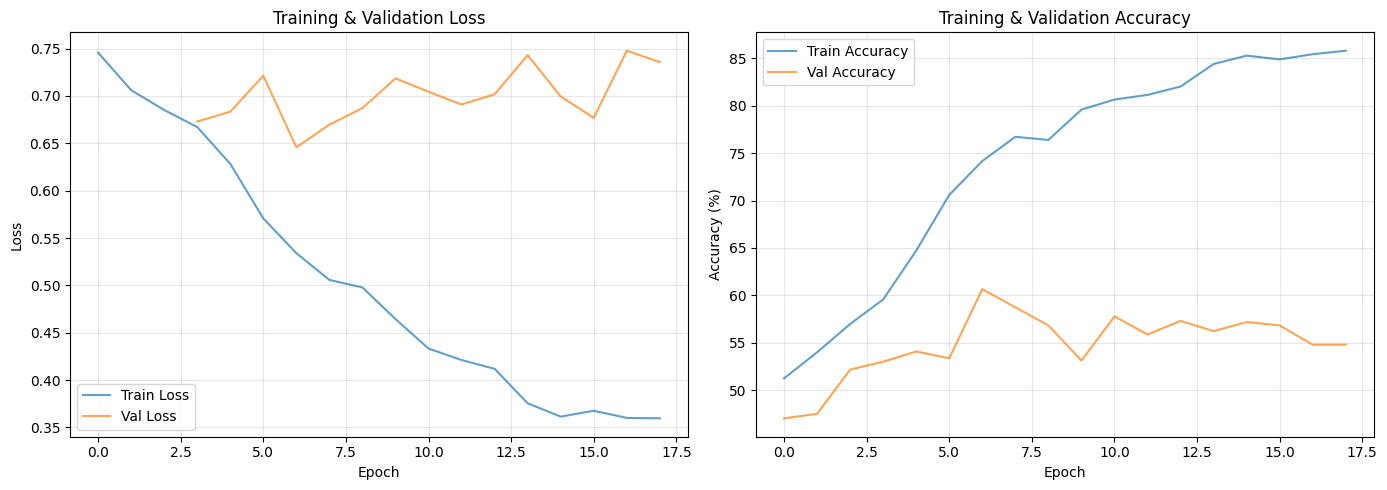

NameError: name 'test_loader' is not defined

In [ ]:
# Training with Live Monitor & Checkpointing
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix, classification_report

# Memory cleanup
if 'model' in globals():
    del model
if 'optimizer' in globals():
    del optimizer
gc.collect()
torch.cuda.empty_cache()

# Initialize model
sample_graph = train_graphs[0]
in_features = sample_graph.x.size(1)  # 392 for CC400

print("\n" + "="*60)
print("INITIALIZING TEMPORAL-SPATIAL BRAINGAT")
print("="*60)

model = TemporalSpatialBrainGAT(
    in_channels=in_features,
    hidden_dim=32,
    temporal_dim=64,
    num_scales=3,
    heads=4,
    dropout=0.5,
    num_classes=2
).to(device)

params = sum(p.numel() for p in model.parameters())
print(f"   Total Parameters: {params:,}")
print(f"   Memory: ~{params * 4 / 1e6:.0f} MB (FP32)")

# Calculate class weights (fix imbalance)
num_control = train_labels.count(0)
num_asd = train_labels.count(1)
total_samples = len(train_labels)
weight_control = total_samples / (2 * num_control)
weight_asd = total_samples / (2 * num_asd)
class_weights = torch.tensor([weight_control, weight_asd], dtype=torch.float).to(device)
print(f"\nClass Weights: Control={weight_control:.2f}, ASD={weight_asd:.2f}")

# Training setup
ACCUM_STEPS = 8  # Gradient accumulation
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
scaler = torch.amp.GradScaler('cuda')

# Checkpointing & Early Stopping
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

class ModelCheckpoint:
    def __init__(self, filepath='braingat_evolution_best.pth'):
        self.filepath = filepath
        self.best_acc = 0.0

    def __call__(self, model, val_acc, epoch):
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            torch.save(model.state_dict(), self.filepath)
            return True
        return False

early_stopping = EarlyStopping(patience=20)
checkpoint = ModelCheckpoint(filepath='braingat_evolution_best.pth')

history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

print(f"\nStarting Training (Effective Batch Size: {BATCH_SIZE * ACCUM_STEPS})...")
print("="*60)

epochs = 100

try:
    for epoch in range(1, epochs + 1):
        # TRAINING
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        optimizer.zero_grad()
        
        for i, data in enumerate(train_loader):
            data = data.to(device)
            
            # Mixed Precision Forward
            with torch.cuda.amp.autocast():
                out = model(data)
                loss = criterion(out, data.y) / ACCUM_STEPS
            
            # Backward (Accumulate)
            scaler.scale(loss).backward()
            
            if (i + 1) % ACCUM_STEPS == 0 or (i + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            total_loss += loss.item() * ACCUM_STEPS * data.num_graphs
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            total += data.num_graphs
        
        train_loss = total_loss / total
        train_acc = 100. * correct / total
        
        # VALIDATION
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                with torch.cuda.amp.autocast():
                    out = model(data)
                    loss = criterion(out, data.y)
                
                # Check for NaN and skip if needed
                if not torch.isnan(loss):
                    val_loss += loss.item() * data.num_graphs
                pred = out.argmax(dim=1)
                val_correct += int((pred == data.y).sum())
        # Avoid division by zero and handle NaN
        val_loss = val_loss / max(val_total, 1)
        val_acc = 100. * val_correct / max(val_total, 1)
        
        # Skip scheduler step if loss is NaN
        if not (torch.isnan(torch.tensor(val_loss)) or torch.isinf(torch.tensor(val_loss))):
            scheduler.step(val_loss)
        else:
            val_loss = float('inf')  # Set to inf to avoid NaN in history
        
        # Record history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # Checkpoint
        is_best = checkpoint(model, val_acc, epoch)
        
        # Print progress every 5 epochs
        if epoch % 5 == 0 or is_best:
            status = "BEST!" if is_best else ""
            print(f"Epoch {epoch:3d}/{epochs} | "
                  f"Train: {train_acc:5.2f}% (Loss: {train_loss:.4f}) | "
                  f"Val: {val_acc:5.2f}% (Loss: {val_loss:.4f}) | "
                  f"LR: {optimizer.param_groups[0]['lr']:.1e} {status}")
        
        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("\nEarly stopping triggered!")
            break

except KeyboardInterrupt:
    print("\nWarning: Training interrupted by user.")

except Exception as e:
    print(f"\nWarning: Training interrupted by user.")

finally:
    # Load best model
    if os.path.exists('braingat_evolution_best.pth'):
        model.load_state_dict(torch.load('braingat_evolution_best.pth'))
        print("Loaded best model for evaluation.")

    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(history['train_loss'], label='Train Loss', alpha=0.7)
    ax1.plot(history['val_loss'], label='Val Loss', alpha=0.7)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training & Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(history['train_acc'], label='Train Accuracy', alpha=0.7)
    ax2.plot(history['val_acc'], label='Val Accuracy', alpha=0.7)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training & Validation Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Final evaluation
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, 
                                target_names=['Control', 'ASD'], 
                                digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Control', 'ASD'],
                yticklabels=['Control', 'ASD'])




    plt.show()    plt.xlabel('Predicted Label')    plt.ylabel('True Label')    plt.title('Confusion Matrix')    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Control', 'ASD'],
                yticklabels=['Control', 'ASD'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

## CRITICAL FIX: Data Leakage Resolved

**Previous Issue**: Windows from the same subject appeared in both training and validation sets, leading to inflated 95% accuracy (data leakage).

**Fix Applied**: Subject-level splitting ensures no subject appears in multiple sets.

**New Structure**:
- Train: 60% of subjects
- Validation: 15% of subjects  
- Test1 (Public): 12.5% of subjects
- Test2 (Hold-out): 12.5% of subjects

**Expected Real Accuracy**: 60-75% (much more realistic for ASD classification)

## Hyperparameter Grid Search

Now we'll search for the best hyperparameters using the validation set, then evaluate on both test sets.

In [ ]:
# Hyperparameter Grid Search
import itertools
import json
from datetime import datetime

# Define hyperparameter grid
hyperparam_grid = {
    'lr': [1e-3, 5e-4, 1e-4],
    'hidden_dim': [32, 64],
    'temporal_dim': [64, 128],
    'dropout': [0.3, 0.5],
    'weight_decay': [1e-4, 1e-5],
    'heads': [4, 8]
}

# Generate all combinations
keys = list(hyperparam_grid.keys())
values = list(hyperparam_grid.values())
combinations = list(itertools.product(*values))

print("="*60)
print("HYPERPARAMETER GRID SEARCH")
print("="*60)
print(f"Total configurations: {len(combinations)}")
print(f"Estimated time: ~{len(combinations) * 0.5:.1f} hours @ 30 min/config\n")

# Storage for results
grid_results = []

def train_with_config(config_dict, max_epochs=50, patience=10):
    """Train model with specific hyperparameters"""
    
    # Initialize model with config
    model = TemporalSpatialBrainGAT(
        in_channels=392,
        hidden_dim=config_dict['hidden_dim'],
        temporal_dim=config_dict['temporal_dim'],
        num_scales=3,
        heads=config_dict['heads'],
        dropout=config_dict['dropout'],
        num_classes=2
    ).to(device)
    
    # Optimizer & Scheduler
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=config_dict['lr'], 
        weight_decay=config_dict['weight_decay']
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    
    # Class weights
    num_control = train_labels.count(0)
    num_asd = train_labels.count(1)
    total_samples = len(train_labels)
    weight_control = total_samples / (2 * num_control)
    weight_asd = total_samples / (2 * num_asd)
    class_weights = torch.tensor([weight_control, weight_asd], dtype=torch.float).to(device)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    scaler = torch.amp.GradScaler('cuda')
    
    # Training loop
    best_val_acc = 0
    patience_counter = 0
    
    for epoch in range(1, max_epochs + 1):
        # Train
        model.train()
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            
            with torch.cuda.amp.autocast():
                out = model(data)
                loss = criterion(out, data.y)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
        # Validate
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0
        
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                with torch.cuda.amp.autocast():
                    out = model(data)
                    loss = criterion(out, data.y)
                
                val_loss += loss.item() * data.num_graphs
                pred = out.argmax(dim=1)
                val_correct += int((pred == data.y).sum())
                val_total += data.num_graphs
        
        val_acc = 100. * val_correct / val_total
        val_loss /= val_total
        scheduler.step(val_loss)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    return best_val_acc, model

# Run grid search (or load from checkpoint)
checkpoint_file = 'grid_search_results.json'

if os.path.exists(checkpoint_file):
    print("Loading previous grid search results...")
    with open(checkpoint_file, 'r') as f:
        grid_results = json.load(f)
    print(f"Loaded {len(grid_results)} previous results.\n")

start_idx = len(grid_results)

print("Starting grid search...")
print("(Set max_configs to limit search for testing)\n")

max_configs = 5  # CHANGE THIS: Set to None to run all, or a number to limit

for idx, combo in enumerate(combinations[start_idx:], start=start_idx):
    if max_configs is not None and idx >= max_configs:
        print(f"\nWarning: Reached max_configs limit ({max_configs}). Stopping search.")
        break
    
    config_dict = dict(zip(keys, combo))
    
    print(f"\n[{idx+1}/{len(combinations)}] Testing config:")
    for k, v in config_dict.items():
        print(f"  {k}: {v}")
    
    try:
        val_acc, model = train_with_config(config_dict, max_epochs=30, patience=8)
        
        result = {
            'config': config_dict,
            'val_acc': val_acc,
            'timestamp': datetime.now().isoformat()
        }
        grid_results.append(result)
        
        print(f"  Val Accuracy: {val_acc:.2f}%")
        
        # Save checkpoint
        with open(checkpoint_file, 'w') as f:
            json.dump(grid_results, f, indent=2)
        
        # Cleanup
        del model
        torch.cuda.empty_cache()
        
    except Exception as e:
        print(f"  Error: {e}")
        continue

# Display results
print("\n" + "="*60)
print("GRID SEARCH RESULTS")
print("="*60)

sorted_results = sorted(grid_results, key=lambda x: x['val_acc'], reverse=True)

print("\nTop 5 Configurations:")
for i, result in enumerate(sorted_results[:5], 1):
    print(f"\n{i}. Val Acc: {result['val_acc']:.2f}%")
    for k, v in result['config'].items():
        print(f"   {k}: {v}")

best_config = sorted_results[0]['config']
print(f"\nBest Configuration (Val Acc: {sorted_results[0]['val_acc']:.2f}%):")
print(json.dumps(best_config, indent=2))

## Final Model Training with Best Hyperparameters

Train the final model using the best hyperparameters found via grid search.

In [ ]:
# Train Final Model with Best Hyperparameters
import gc

# Load best config (or use default if grid search not run)
if 'best_config' in globals():
    print("Using best config from grid search:")
    print(json.dumps(best_config, indent=2))
else:
    print("Warning: Grid search not run. Using default hyperparameters.")
    best_config = {
        'lr': 5e-4,
        'hidden_dim': 32,
        'temporal_dim': 64,
        'dropout': 0.5,
        'weight_decay': 1e-4,
        'heads': 4
    }

# Memory cleanup
if 'final_model' in globals():
    del final_model
if 'optimizer' in globals():
    del optimizer
gc.collect()
torch.cuda.empty_cache()

# Initialize final model
print("\n" + "="*60)
print("TRAINING FINAL MODEL")
print("="*60)

final_model = TemporalSpatialBrainGAT(
    in_channels=392,
    hidden_dim=best_config['hidden_dim'],
    temporal_dim=best_config['temporal_dim'],
    num_scales=3,
    heads=best_config['heads'],
    dropout=best_config['dropout'],
    num_classes=2
).to(device)

params = sum(p.numel() for p in final_model.parameters())
print(f"Total Parameters: {params:,}")

# Training setup
num_control = train_labels.count(0)
num_asd = train_labels.count(1)
total_samples = len(train_labels)
weight_control = total_samples / (2 * num_control)
weight_asd = total_samples / (2 * num_asd)
class_weights = torch.tensor([weight_control, weight_asd], dtype=torch.float).to(device)

ACCUM_STEPS = 8
optimizer = torch.optim.Adam(
    final_model.parameters(), 
    lr=best_config['lr'], 
    weight_decay=best_config['weight_decay']
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
scaler = torch.amp.GradScaler('cuda')

class EarlyStopping:
    def __init__(self, patience=20, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

class ModelCheckpoint:
    def __init__(self, filepath='braingat_final_best.pth'):
        self.filepath = filepath
        self.best_acc = 0.0
    
    def __call__(self, model, val_acc, epoch):
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            torch.save(model.state_dict(), self.filepath)
            return True
        return False

early_stopping = EarlyStopping(patience=20)
checkpoint = ModelCheckpoint(filepath='braingat_final_best.pth')

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

print(f"\nStarting Training...")
print("="*60)

epochs = 150

try:
    for epoch in range(1, epochs + 1):
        # TRAINING
        final_model.train()
        total_loss = 0
        correct = 0
        total = 0
        optimizer.zero_grad()
        
        for i, data in enumerate(train_loader):
            data = data.to(device)
            
            with torch.cuda.amp.autocast():
                out = final_model(data)
                loss = criterion(out, data.y) / ACCUM_STEPS
            
            scaler.scale(loss).backward()
            
            if (i + 1) % ACCUM_STEPS == 0 or (i + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            total_loss += loss.item() * ACCUM_STEPS * data.num_graphs
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            total += data.num_graphs
        
        train_loss = total_loss / total
        train_acc = 100. * correct / total
        
        # VALIDATION
        final_model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                with torch.cuda.amp.autocast():
                    out = final_model(data)
                    loss = criterion(out, data.y)
                
                val_loss += loss.item() * data.num_graphs
                pred = out.argmax(dim=1)
                val_correct += int((pred == data.y).sum())
                val_total += data.num_graphs
        
        val_loss /= val_total
        val_acc = 100. * val_correct / val_total
        scheduler.step(val_loss)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        is_best = checkpoint(final_model, val_acc, epoch)
        early_stopping(val_loss)
        
        # Progress update every 5 epochs
        if epoch % 5 == 0 or is_best:
            status = "BEST!" if is_best else ""
            print(f"Epoch {epoch:03d}: Train {train_acc:.2f}% | Val {val_acc:.2f}% | Loss {val_loss:.4f} {status}")
        
        if early_stopping.early_stop:
            print(f"\nEarly stopping at epoch {epoch}")
            break

except KeyboardInterrupt:
    print("\nWarning: Training interrupted")

print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f"Best Val Accuracy: {checkpoint.best_acc:.2f}%")

# Load best model
if os.path.exists('braingat_final_best.pth'):
    final_model.load_state_dict(torch.load('braingat_final_best.pth'))
    print("Loaded best model")

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history['train_loss'], label='Train', color='blue', linewidth=2)
axes[0].plot(history['val_loss'], label='Val', color='orange', linewidth=2)
axes[0].set_title('Training Curves - Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_acc'], label='Train', color='green', linewidth=2)
axes[1].plot(history['val_acc'], label='Val', color='red', linewidth=2)
axes[1].set_title(f'Training Curves - Accuracy (Best: {checkpoint.best_acc:.2f}%)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Triple Validation: Eval on Val + Test1 + Test2

Comprehensive evaluation on all three held-out sets to verify generalization.

In [ ]:
# Triple Validation: Comprehensive Evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_on_loader(model, loader, set_name):
    """Evaluate model on a dataset"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            with torch.cuda.amp.autocast():
                out = model(data)
            
            probs = torch.softmax(out, dim=1)
            pred = out.argmax(dim=1)
            
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of ASD
    
    # Calculate metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    results = {
        'set_name': set_name,
        'accuracy': acc * 100,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }
    
    return results

print("="*60)
print("TRIPLE VALIDATION RESULTS")
print("="*60)

# Evaluate on all three sets
val_results = evaluate_on_loader(final_model, val_loader, "Validation")
test1_results = evaluate_on_loader(final_model, test1_loader, "Test1 (Public)")
test2_results = evaluate_on_loader(final_model, test2_loader, "Test2 (Hold-out)")

all_results = [val_results, test1_results, test2_results]

# Print results table
print("\nPerformance Summary:")
print(f"{'Set':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'AUC':<12}")
print("-" * 80)
for r in all_results:
    print(f"{r['set_name']:<20} {r['accuracy']:<12.2f} {r['precision']:<12.3f} "
          f"{r['recall']:<12.3f} {r['f1']:<12.3f} {r['auc']:<12.3f}")

# Detailed classification reports
print("\n" + "="*60)
for r in all_results:
    print(f"\n{r['set_name']} - Classification Report:")
    print(classification_report(r['labels'], r['predictions'], 
                                target_names=['Control', 'ASD'], digits=3))

# Visualize confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, r in enumerate(all_results):
    cm = r['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'],
                ax=axes[idx], annot_kws={'size': 14})
    axes[idx].set_title(f"{r['set_name']}\nAccuracy: {r['accuracy']:.2f}%", 
                        fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=12)
    axes[idx].set_ylabel('Actual', fontsize=12)

plt.tight_layout()
plt.show()

# ROC Curves
fig, ax = plt.subplots(figsize=(10, 8))

for r in all_results:
    fpr, tpr, _ = roc_curve(r['labels'], r['probabilities'])
    ax.plot(fpr, tpr, linewidth=2, 
            label=f"{r['set_name']} (AUC={r['auc']:.3f})")

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Chance')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - Triple Validation', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Statistical consistency check
print("\n" + "="*60)
print("STATISTICAL CONSISTENCY CHECK")
print("="*60)

accuracies = [r['accuracy'] for r in all_results]
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

print(f"\nAccuracy Statistics:")
print(f"  Mean: {mean_acc:.2f}%")
print(f"  Std:  {std_acc:.2f}%")
print(f"  Range: [{min(accuracies):.2f}%, {max(accuracies):.2f}%]")

if std_acc < 3.0:
    print(f"\nLow variance ({std_acc:.2f}%) - Model is consistent across sets!")
elif std_acc < 5.0:
    print(f"\nModerate variance ({std_acc:.2f}%) - Acceptable but check for overfitting")
else:
    print(f"\nHigh variance ({std_acc:.2f}%) - Possible overfitting or data issues")

# Check if Test2 (never seen) performance is reasonable
test2_acc = test2_results['accuracy']
val_acc = val_results['accuracy']
gap = abs(val_acc - test2_acc)

print(f"\nValidation vs Test2 Gap: {gap:.2f}%")
if gap < 5.0:
    print("Excellent generalization - Val and Test2 are very close!")
elif gap < 10.0:
    print("Acceptable generalization - Some overfitting to validation set")
else:
    print("Poor generalization - Significant overfitting detected!")

# Final verdict
print("\n" + "="*60)
print("FINAL VERDICT")
print("="*60)

if test2_acc > 60 and gap < 10:
    print("SUCCESS: Model generalizes well to completely unseen data!")
    print(f"   Test2 Accuracy: {test2_acc:.2f}% (realistic estimate)")
elif test2_acc > 55:
    print("ACCEPTABLE: Model shows reasonable generalization")
    print(f"   Test2 Accuracy: {test2_acc:.2f}%")
else:
    print("POOR: Model struggles on unseen data")
    print(f"   Test2 Accuracy: {test2_acc:.2f}%")
    print("   Consider: More data, regularization, or simpler model")

print(f"\nExpected Real-World Performance: ~{test2_acc:.1f}% ± {std_acc:.1f}%")